In [18]:
import numpy as np
import pandas as pd
import networkx as nx
import pandas as pd
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
from scipy.linalg import eigvals
from scipy.cluster.hierarchy import linkage, leaves_list
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [19]:
def compute_graph_metrics(G):
    """Computes the 25 network metrics that do not need rewiring from the paper"""
    
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    degrees = np.array([deg for _, deg in G.degree()])
    max_deg = max(n - 1, 1)

    metrics = {}

    # 1. ⟨k⟩, density (CHECKED)
    metrics["Density (⟨k⟩)"] = nx.density(G)

    # 2. var(k), degree variance, normalized by n-1 (CHECKED)
    normalized_degrees = degrees / max_deg
    metrics["Degree Variance"] = np.var(normalized_degrees)

    # 3. ⟨kn⟩, average neighbor degree, normalized by (n - 1) (CHECKED)
    avg_neighbor_degrees = list(nx.average_neighbor_degree(G).values())
    normalized_avg_neighbor_degrees = [kn_i / max(n - 1, 1) for kn_i in avg_neighbor_degrees]
    metrics["Average Neighbor Degree (⟨kn⟩)"] = np.mean(normalized_avg_neighbor_degrees)

    # 4. var(kn), variance of normalized average neighbor degrees (CHECKED)
    metrics["Neighbor Degree Variance"] = np.var(normalized_avg_neighbor_degrees)

    # 5. ⟨C⟩, average clustering coefficient (CHECKED)
    metrics["Average Clustering Coefficient (⟨C⟩)"] = nx.average_clustering(G)

    # 6. var(C), clustering coefficient variance (CHECKED)
    clustering_values = list(nx.clustering(G).values())
    metrics["Clustering Coefficient Variance"] = np.var(clustering_values)

    # 7. r, degree correlation (assortativity) (CHECKED)
    try:
        assortativity = nx.degree_assortativity_coefficient(G)
        metrics["Degree Correlation (r)"] = assortativity if np.isfinite(assortativity) else 0
    except:
        metrics["Degree Correlation (r)"] = 0

    # Metrics 8-12 are computed in a different functions due to need of rewiring

    # 13. μ, number of modules, normalized by n
    # Convert NetworkX graph to iGraph 
    g_ig = ig.Graph.Adjacency((nx.to_numpy_array(G) > 0).tolist(), mode=ig.ADJ_UNDIRECTED)
    g_ig.vs["name"] = list(G.nodes)

    try:
        clusters = g_ig.community_leading_eigenvector()
        μ = len(clusters)
        metrics["Number of Modules (μ)"] = μ / G.number_of_nodes()
    except:
        metrics["Number of Modules (μ)"] = 0

    # 14. ⟨wn⟩, average node betweenness
    node_betweenness = nx.betweenness_centrality(G)
    metrics["Average Node Betweenness (⟨wn⟩)"] = np.mean(list(node_betweenness.values()))

    # 15. var(wn), node betweenness variance
    metrics["Node Betweenness Variance"] = np.var(list(node_betweenness.values()))

    # 16. ⟨we⟩, average edge betweenness
    edge_betweenness = nx.edge_betweenness_centrality(G)
    metrics["Average Edge Betweenness (⟨we⟩)"] = np.mean(list(edge_betweenness.values()))

    # 17. var(we), edge betweenness variance
    metrics["Edge Betweenness Variance"] = np.var(list(edge_betweenness.values()))

    # 18. ⟨cl⟩, average closeness
    closeness = nx.closeness_centrality(G)
    metrics["Average Closeness (⟨cl⟩)"] = np.mean(list(closeness.values()))

    # 19. var(cl), closeness variance
    metrics["Closeness Variance"] = np.var(list(closeness.values()))

    # 20. ⟨l⟩, average path length, normalized by n-1
    if nx.is_connected(G) and n > 1:
        avg_path_length = nx.average_shortest_path_length(G) / (n - 1)
        metrics["Average Path Length (⟨l⟩)"] = avg_path_length
    else:
        metrics["Average Path Length (⟨l⟩)"] = 0

    # 21. d, diameter
    if nx.is_connected(G) and n > 1:
        diameter = nx.diameter(G)
        metrics["Diameter (d)"] = diameter / (n - 1)
    else:
        metrics["Diameter (d)"] = 0

    # 22. ⟨dd⟩, distance distribution mean
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    path_lengths = [length for target in shortest_paths.values() for length in target.values()]
    path_lengths_normalized = [length / (n - 1) for length in path_lengths]
    metrics["Distance Distribution Mean (⟨dd⟩)"] = np.mean(path_lengths_normalized)

    # 23. var(dd), distance distribution variance
    metrics["Distance Distribution Variance"] = np.var(path_lengths_normalized)

    # 24. l3, number of 3-loops (triangles)
    num_triangles = sum(nx.triangles(G).values()) // 3
    if n >= 3:
        total_triples = n * (n - 1) * (n - 2) / 6
        metrics["3-loops (l3)"] = num_triangles / total_triples
    else:
        metrics["3-loops (l3)"] = 0

    # 25. c4, number of 4-cliques
    num_4_cliques = sum(1 for _ in nx.find_cliques(G) if len(_) == 4)
    if n >= 4:
        total_quadruples = n * (n - 1) * (n - 2) * (n - 3) / 24
        metrics["4-Cliques (c4)"] = num_4_cliques / total_quadruples
    else:
        metrics["4-Cliques (c4)"] = 0

    # 26. s4, number of 4-stars normalized by 4-tuples
    num_4_stars = sum((G.degree(node) * (G.degree(node) - 1) * (G.degree(node) - 2)) // 6
                    for node in G.nodes if G.degree(node) >= 3)
    if n >= 4:
        total_quadruples = n * (n - 1) * (n - 2) * (n - 3) / 24
        metrics["4-Stars (s4)"] = num_4_stars / total_quadruples
    else:
        metrics["4-Stars (s4)"] = 0

    # 27. G, graph energy (sum of absolute eigenvalues of adjacency matrix), normalized by n^1.5
    adj_matrix = nx.to_numpy_array(G)
    eigenvalues = np.linalg.eigvals(adj_matrix)
    metrics["Graph Energy (G)"] = np.sum(np.abs(eigenvalues)) / (n ** 1.5)

    # 28. ⟨eC⟩, average eigencentrality
    eigencentrality = nx.eigenvector_centrality_numpy(G)
    metrics["Average EigenCentrality (⟨eC⟩)"] = np.mean(list(eigencentrality.values()))

    # 29. var(eC), eigencentrality variance
    metrics["EigenCentrality Variance"] = np.var(list(eigencentrality.values()))

    # 30. a, algebraic connectivity
    laplacian_matrix = nx.laplacian_matrix(G).todense()
    laplacian_spectrum = np.linalg.eigvalsh(laplacian_matrix)  # safer for symmetric matrices
    if len(laplacian_spectrum) > 1 and n > 1:
        algebraic_connectivity = sorted(laplacian_spectrum)[1]
        metrics["Algebraic Connectivity (a)"] = algebraic_connectivity
    else:
        metrics["Algebraic Connectivity (a)"] = 0

    return metrics

In [20]:
def compute_graph_metrics_with_rewiring(G, rewiring_reps=100):
    """Computes rewiring-based metrics (Metrics 8–12) with shared rewiring samples."""
    m = G.number_of_edges()
    metrics = {}

    # Original graph: rich-club coefficients and s-metric
    rich_club_real = nx.rich_club_coefficient(G, normalized=False)
    s_current = sum(G.degree(u) * G.degree(v) for u, v in G.edges())

    # Accumulators
    assortativities = []
    rich_club_random_sums = {k: 0 for k in rich_club_real}
    s_vals = []
    successful_reps = 0

    # Conservative rewiring parameters for small graphs
    nswap = min(2 * m, m + 10)
    max_tries = nswap * 20

    for _ in range(rewiring_reps):
        G_rewired = copy.deepcopy(G)
        try:
            # Attempt edge rewiring
            nx.double_edge_swap(G_rewired, nswap=nswap, max_tries=max_tries)

            # Metric 8: Degree assortativity coefficient (r)
            r = nx.degree_assortativity_coefficient(G_rewired)
            assortativities.append(r)

            # Metric 9–10: Rich-club coefficient (unnormalized)
            rc_rand = nx.rich_club_coefficient(G_rewired, normalized=False)
            for k in rich_club_real:
                rich_club_random_sums[k] += rc_rand.get(k, 0)

            # Metric 11–12: s-metric
            s = sum(G_rewired.degree(u) * G_rewired.degree(v) for u, v in G_rewired.edges())
            s_vals.append(s)

            successful_reps += 1

        except (nx.NetworkXError, nx.NetworkXAlgorithmError):
            # Rewiring failed, skip this iteration
            continue

    clean_r = [r for r in assortativities if np.isfinite(r)]
    if clean_r:
        metrics["Degree Correlation Elasticity (|rmax - rmin|)"] = max(clean_r) - min(clean_r)
    else:
        metrics["Degree Correlation Elasticity (|rmax - rmin|)"] = 0

    # Metric 9–10: Rich-club mean and variance (normalized)
    if successful_reps > 0:
        rich_club_random_avg = {
            k: rich_club_random_sums[k] / successful_reps for k in rich_club_real
        }
        normalized_rc = [
            rich_club_real[k] / rich_club_random_avg[k]
            for k in rich_club_real if rich_club_random_avg.get(k, 0) > 0
        ]
        metrics["Rich Club Metric (⟨rc⟩)"] = np.mean(normalized_rc) if normalized_rc else 0
        metrics["Rich Club Variance"] = np.var(normalized_rc) if normalized_rc else 0
    else:
        metrics["Rich Club Metric (⟨rc⟩)"] = 0
        metrics["Rich Club Variance"] = 0

    # Metric 11–12: s-metric ratio and elasticity
    if s_vals:
        s_max, s_min = max(s_vals), min(s_vals)
        metrics["s-metric/smax"] = s_current / s_max if s_max != 0 else 0
        metrics["s-metric Elasticity (|smax - smin|)"] = abs(s_max - s_min) / s_max if s_max != 0 else 0
    else:
        metrics["s-metric/smax"] = 0
        metrics["s-metric Elasticity (|smax - smin|)"] = 0

    return metrics

In [21]:
SEED = 42
np.random.seed(SEED)

In [22]:
unique_graph_hashes = set()

def generate_unique_connected_graph(node=14):
    while True:
        edge_count = int(np.random.pareto(2.5) * 15)
        edge_count = min(max(edge_count, node), node * (node - 1) // 2)
        G = nx.gnm_random_graph(node, edge_count)
        if nx.is_connected(G):
            graph_hash = weisfeiler_lehman_graph_hash(G)
            if graph_hash not in unique_graph_hashes:
                unique_graph_hashes.add(graph_hash)
                return G

def get_graph_structure(G, graph_id):
    adj_matrix = nx.to_numpy_array(G, dtype=int).flatten()
    return {
        "graph_structure": list(adj_matrix),
        "graph_id": graph_id,
        "node_count": len(G.nodes)
    }

In [23]:
# Generate graphs with node counts of 8, 10, 12, and 14, for a total of 20000 graphs
# Define how many graphs per node count
node_counts = [8, 10, 12, 14]
graphs_per_count = 100  # Use a lower value for testing
graphs = []

for node_count in node_counts:
    for _ in tqdm(range(graphs_per_count), desc=f"n={node_count}"):
        graphs.append(generate_unique_connected_graph(node=node_count))

n=14: 100%|██████████| 100/100 [00:00<00:00, 1783.79it/s]


In [24]:
with open("graphs.pkl", "wb") as f:
    pickle.dump(graphs, f)

In [25]:
combined_data = []

for i, G in enumerate(tqdm(graphs, desc="Processing graphs")):
    base_metrics = compute_graph_metrics(G)
    rewire_metrics = compute_graph_metrics_with_rewiring(G, rewiring_reps=30)
    structure_info = get_graph_structure(G, i)

    full_data = {
        **base_metrics,
        **rewire_metrics,
        **structure_info
    }
    combined_data.append(full_data)

# create DataFrame
df_combined = pd.DataFrame(combined_data)

Processing graphs:   0%|          | 0/400 [00:00<?, ?it/s]c:\Users\54349\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
Processing graphs: 100%|██████████| 400/400 [00:23<00:00, 17.25it/s]


In [26]:
with open("graph_dataset.pkl", "wb") as f:
    pickle.dump(df_combined, f)

In [27]:
with open("graph_dataset.pkl", "rb") as f:
    df_combined = pickle.load(f)

In [28]:
df_metrics = df_combined.drop(columns=["graph_structure", "graph_id", "node_count"], errors="ignore")

corr_matrix = df_metrics.corr()
linkage_matrix = linkage(corr_matrix, method="ward")
ordered_cols = leaves_list(linkage_matrix)
df_metrics_clustered = df_metrics.iloc[:, ordered_cols]

In [29]:
# --- STEP 1: PCA setup ---
df_combined_dr = df_combined.dropna(subset=df_combined.columns.difference(['graph_id', 'graph_structure', 'node_count'])).copy()
df_numeric = df_combined_dr.drop(columns=["graph_id", "graph_structure", "node_count"], errors='ignore')
df_real = df_numeric.applymap(lambda x: x.real if isinstance(x, complex) else x)
df_standardized = (df_real - df_real.mean()) / df_real.std()

C:\Users\54349\AppData\Local\Temp\ipykernel_57772\131107381.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_real = df_numeric.applymap(lambda x: x.real if isinstance(x, complex) else x)


In [30]:
pca = PCA(n_components=3)
pc_scores = pca.fit_transform(df_standardized)

# 新增 PC 列，只写入 df_combined_dm
df_combined_dr["PC1"] = pc_scores[:, 0]
df_combined_dr["PC2"] = pc_scores[:, 1]
df_combined_dr["PC3"] = pc_scores[:, 2]

In [31]:
explained_var = pca.explained_variance_ratio_
loadings = pd.DataFrame(pca.components_.T, 
                        columns=["PC1", "PC2", "PC3"], 
                        index=df_standardized.columns)

In [32]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(df_standardized)

# 保存结果
df_combined_dr["TSNE1"] = tsne_results[:, 0]
df_combined_dr["TSNE2"] = tsne_results[:, 1]

In [33]:
with open("graph_dataset_with_dimension_reduction.pkl", "wb") as f:
    pickle.dump(df_combined_dr, f)

In [34]:
df_combined_dr.to_csv("graph_dataset_with_dimension_reduction.csv", index=False)

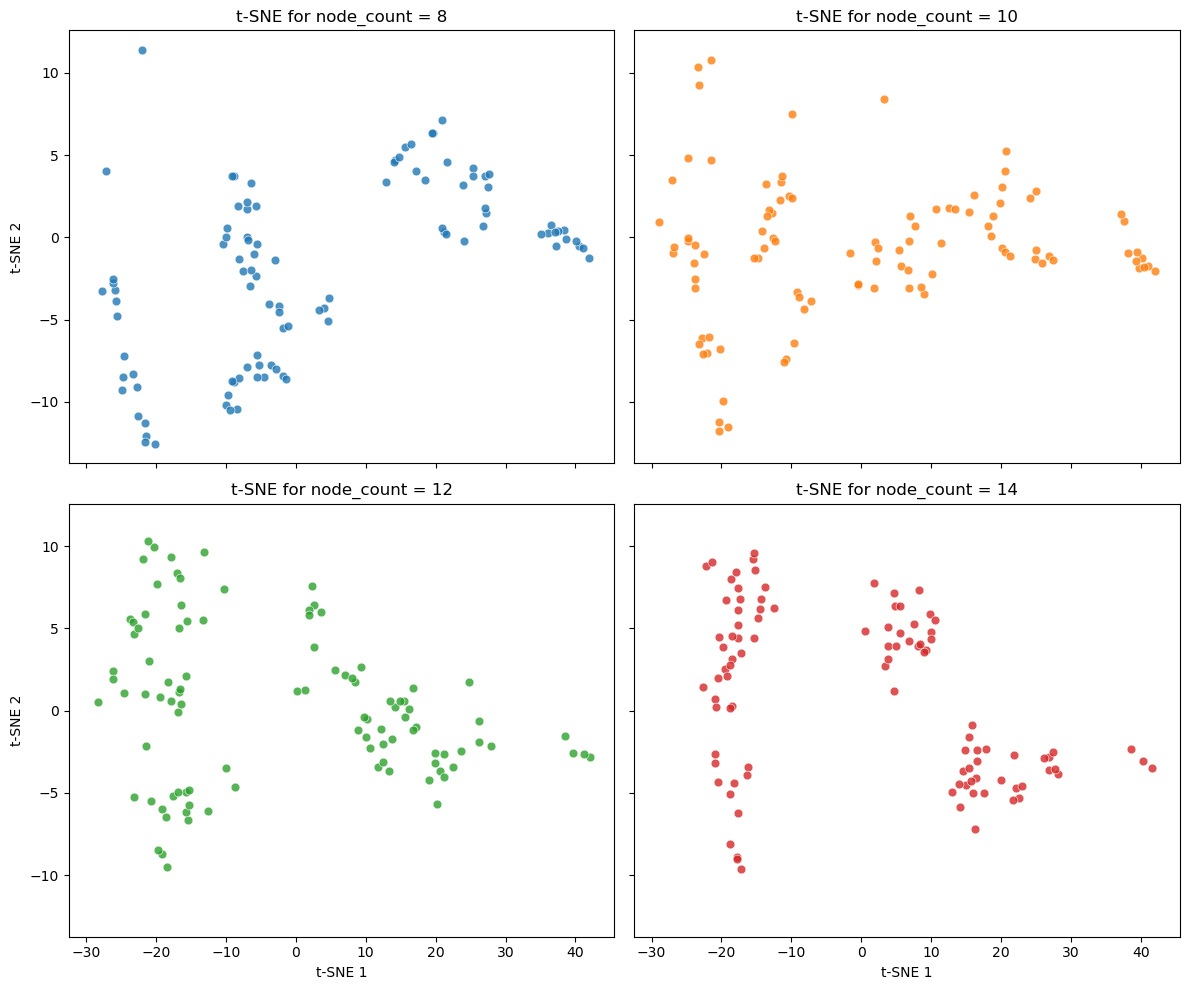

In [35]:
# 获取 node_count 的唯一值（应为 4 个：8, 10, 12, 14）
node_counts = sorted(df_combined_dr["node_count"].unique())

# 自定义颜色映射（可自定义颜色）
color_map = {
    8: "#1f77b4",   # 蓝
    10: "#ff7f0e",  # 橙
    12: "#2ca02c",  # 绿
    14: "#d62728",  # 红
}

# 创建 2x2 子图布局
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

for ax, nc in zip(axes.flatten(), node_counts):
    subset = df_combined_dr[df_combined_dr["node_count"] == nc]
    sns.scatterplot(
        data=subset,
        x="TSNE1",
        y="TSNE2",
        color=color_map[nc],  # 用预设颜色
        s=40,
        alpha=0.8,
        ax=ax
    )
    ax.set_title(f"t-SNE for node_count = {nc}")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()